# Explore here

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

PROJECT_ROOT = Path.cwd() if (Path.cwd() / "data").exists() else Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("MODELS_DIR:", MODELS_DIR)

PROJECT_ROOT: /workspaces/mati-random-forest-project
PROCESSED_DIR: /workspaces/mati-random-forest-project/data/processed
MODELS_DIR: /workspaces/mati-random-forest-project/models


In [16]:
from sklearn.datasets import load_diabetes as _load_diabetes

try:
    from sklearn.datasets import load_breast_cancer as _load_breast_cancer
    _HAS_CANCER = True
except Exception:
    _HAS_CANCER = False

dataset_path = PROCESSED_DIR / "diabetes.csv"

if not dataset_path.exists():
    if _HAS_CANCER:
        data = _load_breast_cancer(as_frame=True)
        df = data.frame
        df.to_csv(dataset_path, index=False)
        print("Dataset (breast_cancer) guardado en:", dataset_path)
    else:
        raise RuntimeError("Tu sklearn no tiene dataset binario rápido para clasificación.")
else:
    print("Dataset ya existe en:", dataset_path)

df = pd.read_csv(dataset_path)
print(df.shape)
df.head()



Dataset (breast_cancer) guardado en: /workspaces/mati-random-forest-project/data/processed/diabetes.csv
(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [17]:
target_col = "target" if "target" in df.columns else df.columns[-1]

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (455, 30)
X_test: (114, 30)
y_train: (455,)
y_test: (114,)


In [18]:
rf_baseline = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced"
)

rf_baseline.fit(X_train, y_train)

y_pred = rf_baseline.predict(X_test)
print("Accuracy (baseline):", accuracy_score(y_test, y_pred))

Accuracy (baseline): 0.9473684210526315


In [19]:
depth_values = [None, 3, 5, 7, 10, 15]
leaf_values = [1, 2, 4, 8, 16]

rows = []

for d in depth_values:
    for leaf in leaf_values:
        model = RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight="balanced",
            max_depth=d,
            min_samples_leaf=leaf
        )
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        rows.append({
            "max_depth": -1 if d is None else d,
            "min_samples_leaf": leaf,
            "accuracy": accuracy_score(y_test, pred)
        })

df_res = pd.DataFrame(rows)
df_res.sort_values("accuracy", ascending=False).head(10)


,max_depth,min_samples_leaf,accuracy
0,-1,1,0.947368
1,-1,2,0.947368
10,5,1,0.947368
11,5,2,0.947368
16,7,2,0.947368
15,7,1,0.947368
21,10,2,0.947368
20,10,1,0.947368
25,15,1,0.947368
26,15,2,0.947368


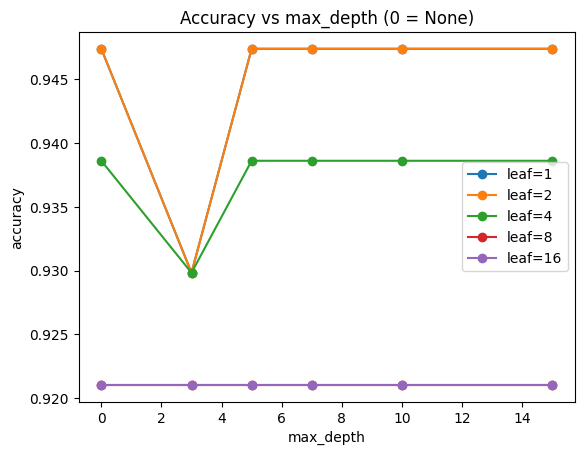

In [20]:
df_plot = df_res.copy()
df_plot["max_depth_plot"] = df_plot["max_depth"].replace(-1, 0)

plt.figure()
for leaf in sorted(df_plot["min_samples_leaf"].unique()):
    sub = df_plot[df_plot["min_samples_leaf"] == leaf].sort_values("max_depth_plot")
    plt.plot(sub["max_depth_plot"], sub["accuracy"], marker="o", label="leaf=" + str(leaf))

plt.title("Accuracy vs max_depth (0 = None)")
plt.xlabel("max_depth")
plt.ylabel("accuracy")
plt.legend()
plt.show()


In [21]:
best_row = df_res.sort_values("accuracy", ascending=False).iloc[0]
best_depth = None if int(best_row["max_depth"]) == -1 else int(best_row["max_depth"])
best_leaf = int(best_row["min_samples_leaf"])

rf_best = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced",
    max_depth=best_depth,
    min_samples_leaf=best_leaf
)

rf_best.fit(X_train, y_train)

pred_best = rf_best.predict(X_test)
print("Accuracy (best):", accuracy_score(y_test, pred_best))
print("Best config:", {"max_depth": best_depth, "min_samples_leaf": best_leaf})

Accuracy (best): 0.9473684210526315
Best config: {'max_depth': None, 'min_samples_leaf': 1}


In [22]:
results_path = PROCESSED_DIR / "rf_hyperparam_results.csv"
df_res.to_csv(results_path, index=False)
print("Resultados guardados en:", results_path)

model_path = MODELS_DIR / "random_forest_diabetes.joblib"
joblib.dump(rf_best, model_path)
print("Modelo guardado en:", model_path)

Resultados guardados en: /workspaces/mati-random-forest-project/data/processed/rf_hyperparam_results.csv
Modelo guardado en: /workspaces/mati-random-forest-project/models/random_forest_diabetes.joblib
